In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class FCN(nn.Module):
    """Defines a fully connected neural network"""

    def __init__(self, input_dim, output_dim, hidden_dim, num_hidden_layers):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_hidden_layers = num_hidden_layers
        self.layer = []
        self.layer.append(nn.Linear(input_dim, hidden_dim))
        self.layer.append(nn.Tanh())
        for i in range(num_hidden_layers):
            self.layer.append(nn.Linear(hidden_dim, hidden_dim))
            self.layer.append(nn.Tanh())
        self.layer.append(nn.Linear(hidden_dim, output_dim))
        self.model = nn.Sequential(*self.layer)

    def forward(self, x):
        return self.model(x)

In [ ]:
pinn = FCN(input_dim=3, output_dim=2, hidden_dim=20, num_hidden_layers=8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pinn.to(device)

mse_cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# -------------------------- 0. 设备定义 --------------------------
# Ensure CUDA is available and used for high-performance training
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# -------------------------- 1. 物理参数与几何定义 --------------------------

Re = 100.0
U_INF = 1.0  # Inlet uniform velocity
D = 0.1  # Cylinder diameter
NU = U_INF * D / Re  # Kinematic viscosity nu = U*D/Re

# Domain [X_min, X_max] x [Y_min, Y_max] x [T_min, T_max]
DOMAIN_X = [-1.0, 5.0]
DOMAIN_Y = [-2.0, 2.0]
DOMAIN_T = [0.0, 5.0]

# Cylinder center and radius
CYL_CENTER = torch.tensor([0.0, 0.0], device=DEVICE)
CYL_R = D / 2.0

# Sampling point numbers
N_f = 20000  # PDE Collocation points
N_cyl = 1000 # Cylinder boundary points
N_in = 1000  # Inlet boundary points
N_wall = 1000# Top/Bottom wall boundary points
N_out = 1000 # Outlet boundary points
N_ic = 2000  # Initial condition points

# -------------------------- 2. 神经网络模型 --------------------------

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input: (x, y, t) -> 3. Output: (psi, p) -> 2
        self.net = nn.Sequential(
            nn.Linear(3, 30), nn.Tanh(),
            nn.Linear(30, 30), nn.Tanh(),
            nn.Linear(30, 30), nn.Tanh(),
            nn.Linear(30, 30), nn.Tanh(),
            nn.Linear(30, 30), nn.Tanh(),
            nn.Linear(30, 30), nn.Tanh(),
            nn.Linear(30, 30), nn.Tanh(),
            nn.Linear(30, 2)
        ).to(DEVICE)
        self.init_weights()

    def init_weights(self):
        def init(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        self.apply(init)

    def forward(self, x):
        return self.net(x)

# -------------------------- 3. 点采样与数据准备 (更健壮的版本) --------------------------

def sample_points():
    # --- 1. PDE Collocation Points (X_f) ---
    # Generate points in the full domain
    x_f_raw = torch.rand(N_f, 1, device=DEVICE) * (DOMAIN_X[1] - DOMAIN_X[0]) + DOMAIN_X[0]
    y_f_raw = torch.rand(N_f, 1, device=DEVICE) * (DOMAIN_Y[1] - DOMAIN_Y[0]) + DOMAIN_Y[0]
    t_f = torch.rand(N_f, 1, device=DEVICE) * (DOMAIN_T[1] - DOMAIN_T[0]) + DOMAIN_T[0]
    
    # Filter points outside the cylinder (this step is the known cause of the graph issue)
    dist_sq = (x_f_raw - CYL_CENTER[0])**2 + (y_f_raw - CYL_CENTER[1])**2
    is_outside = dist_sq >= CYL_R**2
    
    # Filter and concatenate
    X_f = torch.cat([x_f_raw, y_f_raw, t_f], dim=1)[is_outside.squeeze()].requires_grad_(True)

    # --- 2. Initial Condition Points (X_ic) ---
    x_ic = torch.rand(N_ic, 1, device=DEVICE) * (DOMAIN_X[1] - DOMAIN_X[0]) + DOMAIN_X[0]
    y_ic = torch.rand(N_ic, 1, device=DEVICE) * (DOMAIN_Y[1] - DOMAIN_Y[0]) + DOMAIN_Y[0]
    t_ic = torch.zeros(N_ic, 1, device=DEVICE)
    dist_sq_ic = (x_ic - CYL_CENTER[0])**2 + (y_ic - CYL_CENTER[1])**2
    is_outside_ic = dist_sq_ic >= CYL_R**2
    X_ic = torch.cat([x_ic, y_ic, t_ic], dim=1)[is_outside_ic.squeeze()].requires_grad_(True)
    
    # --- 3. Boundary Condition Points (Separated for robustness) ---
    
    # a) Cylinder Boundary (No-slip, psi=0)
    theta = torch.rand(N_cyl, 1, device=DEVICE) * 2 * np.pi
    x_cyl = CYL_R * torch.cos(theta) + CYL_CENTER[0]
    y_cyl = CYL_R * torch.sin(theta) + CYL_CENTER[1]
    t_cyl = torch.rand(N_cyl, 1, device=DEVICE) * (DOMAIN_T[1] - DOMAIN_T[0]) + DOMAIN_T[0]
    X_cyl = torch.cat([x_cyl, y_cyl, t_cyl], dim=1).requires_grad_(True)

    # b) Inlet Boundary (Uniform flow, x = DOMAIN_X[0])
    x_in = torch.ones(N_in, 1, device=DEVICE) * DOMAIN_X[0]
    y_in = torch.rand(N_in, 1, device=DEVICE) * (DOMAIN_Y[1] - DOMAIN_Y[0]) + DOMAIN_Y[0]
    t_in = torch.rand(N_in, 1, device=DEVICE) * (DOMAIN_T[1] - DOMAIN_T[0]) + DOMAIN_T[0]
    X_in = torch.cat([x_in, y_in, t_in], dim=1).requires_grad_(True)

    # c) Wall Boundary (Top/Bottom, No-slip)
    x_wall_top = torch.rand(N_wall//2, 1, device=DEVICE) * (DOMAIN_X[1] - DOMAIN_X[0]) + DOMAIN_X[0]
    y_wall_top = torch.ones(N_wall//2, 1, device=DEVICE) * DOMAIN_Y[1]
    t_wall_top = torch.rand(N_wall//2, 1, device=DEVICE) * (DOMAIN_T[1] - DOMAIN_T[0]) + DOMAIN_T[0]

    x_wall_bot = torch.rand(N_wall - N_wall//2, 1, device=DEVICE) * (DOMAIN_X[1] - DOMAIN_X[0]) + DOMAIN_X[0]
    y_wall_bot = torch.ones(N_wall - N_wall//2, 1, device=DEVICE) * DOMAIN_Y[0]
    t_wall_bot = torch.rand(N_wall - N_wall//2, 1, device=DEVICE) * (DOMAIN_T[1] - DOMAIN_T[0]) + DOMAIN_T[0]
    
    # Concatenate top and bottom wall points
    X_wall_top = torch.cat([x_wall_top, y_wall_top, t_wall_top], dim=1)
    X_wall_bot = torch.cat([x_wall_bot, y_wall_bot, t_wall_bot], dim=1)
    X_wall = torch.cat([X_wall_top, X_wall_bot], dim=0).requires_grad_(True)

    # d) Outlet Boundary (Soft boundary, x = DOMAIN_X[1], p_x=0)
    x_out = torch.ones(N_out, 1, device=DEVICE) * DOMAIN_X[1]
    y_out = torch.rand(N_out, 1, device=DEVICE) * (DOMAIN_Y[1] - DOMAIN_Y[0]) + DOMAIN_Y[0]
    t_out = torch.rand(N_out, 1, device=DEVICE) * (DOMAIN_T[1] - DOMAIN_T[0]) + DOMAIN_T[0]
    X_out = torch.cat([x_out, y_out, t_out], dim=1).requires_grad_(True)
    
    return X_f, X_ic, X_cyl, X_in, X_wall, X_out

# -------------------------- 4. PINN 核心实现 --------------------------

class NavierStokesPINN:
    def __init__(self, X_f, X_ic, X_cyl, X_in, X_wall, X_out):
        self.model = Net()
        self.X_f, self.X_ic = X_f, X_ic
        self.X_cyl, self.X_in = X_cyl, X_in
        self.X_wall, self.X_out = X_wall, X_out
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.mse = nn.MSELoss()

    @staticmethod
    def _safe_grad(output, input, **kwargs):
        """
        Calculates gradient safely, allowing for unused inputs in the graph 
        (due to data slicing) and replacing None results with zero tensors.
        This prevents RuntimeErrors when performing higher-order differentiation.
        """
        # Ensure allow_unused is always True for robustness with filtered data
        kwargs['allow_unused'] = True
        
        # Calculate gradient
        grad_result = torch.autograd.grad(output, input, **kwargs)[0]
        
        # If gradient is None (due to graph break), replace it with a zero tensor
        if grad_result is None:
            # We return a zero tensor of the same size as the output tensor,
            # which prevents subsequent arithmetic and gradient calls from failing.
            return torch.zeros_like(output) 
        return grad_result

    def net_output(self, X):
        # Extracts x, y, t
        x, y, t = X[:, 0:1], X[:, 1:2], X[:, 2:3]
        
        # Forward pass: psi, p
        res = self.model(X)
        psi, p = res[:, 0:1], res[:, 1:2]
        
        # Create a tensor of ones for grad_outputs
        ones = torch.ones_like(psi) 

        # ------------------ Automatic Differentiation ------------------
        
        # Velocity u = d(psi)/dy, v = -d(psi)/dx
        # Use _safe_grad for all derivatives
        
        # First-order derivatives of psi
        grad_psi_y = self._safe_grad(psi, y, grad_outputs=ones, create_graph=True)
        grad_psi_x = self._safe_grad(psi, x, grad_outputs=ones, create_graph=True)

        # Calculate velocities
        u = grad_psi_y
        v = -1. * grad_psi_x
        
        # N-S residual derivatives
        
        # u_t, v_t
        u_t = self._safe_grad(u, t, grad_outputs=ones, create_graph=True)
        v_t = self._safe_grad(v, t, grad_outputs=ones, create_graph=True)

        # First derivatives (Spatial)
        u_x = self._safe_grad(u, x, grad_outputs=ones, create_graph=True)
        u_y = self._safe_grad(u, y, grad_outputs=ones, create_graph=True)
        v_x = self._safe_grad(v, x, grad_outputs=ones, create_graph=True)
        v_y = self._safe_grad(v, y, grad_outputs=ones, create_graph=True)

        # Second derivatives 
        u_xx = self._safe_grad(u_x, x, grad_outputs=ones, create_graph=True)
        u_yy = self._safe_grad(u_y, y, grad_outputs=ones, create_graph=True)
        v_xx = self._safe_grad(v_x, x, grad_outputs=ones, create_graph=True)
        v_yy = self._safe_grad(v_y, y, grad_outputs=ones, create_graph=True)
        
        # Pressure derivatives
        p_x = self._safe_grad(p, x, grad_outputs=ones, create_graph=True)
        p_y = self._safe_grad(p, y, grad_outputs=ones, create_graph=True)

        # N-S Momentum Residuals (R_u, R_v)
        R_u = u_t + u * u_x + v * u_y + p_x - NU * (u_xx + u_yy)
        R_v = v_t + u * v_x + v * v_y + p_y - NU * (v_xx + v_yy)

        return u, v, psi, p, R_u, R_v

    def loss_func(self):
        # --- 1. Physics Loss (PDE Loss) ---
        _, _, _, _, R_u, R_v = self.net_output(self.X_f)
        loss_f = self.mse(R_u, torch.zeros_like(R_u)) + self.mse(R_v, torch.zeros_like(R_v))
        
        # --- 2. Initial Condition Loss (IC Loss) ---
        u_ic, v_ic, psi_ic, _, _, _ = self.net_output(self.X_ic)
        x_ic, y_ic = self.X_ic[:, 0:1], self.X_ic[:, 1:2]
        
        # IC velocity U_inf, V=0
        loss_ic_v = self.mse(u_ic, torch.ones_like(u_ic) * U_INF) + self.mse(v_ic, torch.zeros_like(v_ic))
        # IC stream function psi = U_inf * y
        loss_ic_psi = self.mse(psi_ic, U_INF * y_ic)
        loss_ic = loss_ic_v + loss_ic_psi

        # --- 3. Boundary Loss (BC Loss) ---
        
        # a) Cylinder Boundary (X_cyl) - No-slip (u=0, v=0), psi=0
        u_cyl, v_cyl, psi_cyl, _, _, _ = self.net_output(self.X_cyl)
        loss_cyl = self.mse(u_cyl, torch.zeros_like(u_cyl)) + self.mse(v_cyl, torch.zeros_like(v_cyl))
        loss_cyl += self.mse(psi_cyl, torch.zeros_like(psi_cyl)) 

        # b) Inlet Boundary (X_in) - Uniform flow (u=U_inf, v=0), psi=U_inf*y
        u_in, v_in, psi_in, _, _, _ = self.net_output(self.X_in)
        y_in = self.X_in[:, 1:2]
        loss_inlet = self.mse(u_in, torch.ones_like(u_in) * U_INF) + self.mse(v_in, torch.zeros_like(v_in))
        loss_inlet += self.mse(psi_in, U_INF * y_in)
        
        # c) Wall Boundary (X_wall) - Top/Bottom No-slip (u=0, v=0)
        u_wall, v_wall, _, _, _, _ = self.net_output(self.X_wall)
        loss_wall = self.mse(u_wall, torch.zeros_like(u_wall)) + self.mse(v_wall, torch.zeros_like(v_wall))
        
        # d) Outlet Boundary (X_out) - Soft boundary (p_x=0)
        x_out = self.X_out[:, 0:1]
        _, _, _, p_out, _, _ = self.net_output(self.X_out)
        
        # Calculate p_x at the outlet
        ones_out = torch.ones_like(p_out)
        p_x_out = self._safe_grad(p_out, x_out, grad_outputs=ones_out, create_graph=True)
        
        loss_outlet = self.mse(p_x_out, torch.zeros_like(p_x_out))
        
        loss_bc = loss_cyl + loss_inlet + loss_wall + loss_outlet

        # --- Total Loss (Weighting can be adjusted) ---
        w_f, w_ic, w_bc = 1.0, 10.0, 10.0 
        
        total_loss = w_f * loss_f + w_ic * loss_ic + w_bc * loss_bc
        
        return total_loss, loss_f.item(), loss_ic.item(), loss_bc.item()

    def train(self, epochs):
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            # 重新采样 PDE 点以提高收敛性
            self.X_f, _, _, _, _, _ = sample_points() 
            
            loss, loss_f, loss_ic, loss_bc = self.loss_func()
            loss.backward()
            self.optimizer.step()
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Total Loss: {loss.item():.6f}, "
                      f"PDE Loss: {loss_f:.6f}, IC Loss: {loss_ic:.6f}, BC Loss: {loss_bc:.6f}")
        return self.model

# -------------------------- 5. 运行模拟 --------------------------

# Update sample_points to return all six tensors
X_f, X_ic, X_cyl, X_in, X_wall, X_out = sample_points()
pinn_solver = NavierStokesPINN(X_f, X_ic, X_cyl, X_in, X_wall, X_out)

# Running for 2000 epochs with Adam is often just a start for this complex problem.
EPOCHS = 2000 
print(f"开始训练 PINN (Re={Re}, 纯物理驱动) on {DEVICE}...")
trained_model = pinn_solver.train(epochs=EPOCHS) 
print("训练完成。")

Using device: cuda:0
开始训练 PINN (Re=100.0, 纯物理驱动) on cuda:0...


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

开始训练PINN模型...


RuntimeError: One of the differentiated Tensors does not require grad

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 物理参数
nu = 0.01  # 运动粘度
rho = 1.0  # 密度
inlet_velocity = 1.0  # 入口速度

class PINN_NavierStokes():
    def __init__(self, layers, cylinder_center=(0.5, 0.2), cylinder_radius=0.05):
        # 网络结构
        self.layers = layers
        self.cylinder_center = cylinder_center
        self.cylinder_radius = cylinder_radius
        
        # 初始化网络
        self.network()
        
        # 优化器
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=0.1, 
            max_iter=1000, 
            max_eval=1000,
            history_size=50, 
            tolerance_grad=1e-07, 
            tolerance_change=1e-09,
            line_search_fn="strong_wolfe"
        )
        
        self.mse = nn.MSELoss()
        self.iter = 0

    def network(self):
        """构建神经网络"""
        layers_list = []
        for i in range(len(self.layers) - 1):
            layer = nn.Linear(self.layers[i], self.layers[i+1])
            # 初始化权重
            if i < len(self.layers) - 2:
                nn.init.xavier_uniform_(layer.weight)
            else:
                nn.init.xavier_uniform_(layer.weight)
            layers_list.append(layer)
            if i < len(self.layers) - 2:  # 最后一层不需要激活函数
                layers_list.append(nn.Tanh())
        
        self.net = nn.Sequential(*layers_list)

    def governing_equations(self, x, y, t):
        """计算Navier-Stokes方程的残差"""
        # 确保输入张量需要梯度
        x = x.requires_grad_(True)
        y = y.requires_grad_(True)
        t = t.requires_grad_(True)
        
        # 网络输出: [u, v, p] (速度分量和压力)
        input_tensor = torch.cat([x, y, t], dim=1)
        output = self.net(input_tensor)
        u, v, p = output[:, 0:1], output[:, 1:2], output[:, 2:3]
        
        # 计算速度的偏导数
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
        
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
        
        # 压力梯度
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        
        # Navier-Stokes方程残差
        f = u_t + u * u_x + v * u_y + (1.0/rho) * p_x - nu * (u_xx + u_yy)
        g = v_t + u * v_x + v * v_y + (1.0/rho) * p_y - nu * (v_xx + v_yy)
        
        # 连续性方程残差 (质量守恒)
        continuity = u_x + v_y
        
        return u, v, p, f, g, continuity

    def boundary_conditions(self, x, y, t):
        """计算边界条件损失"""
        # 确保输入张量需要梯度
        x = x.requires_grad_(True)
        y = y.requires_grad_(True)
        t = t.requires_grad_(True)
        
        # 网络输出
        input_tensor = torch.cat([x, y, t], dim=1)
        output = self.net(input_tensor)
        u, v, p = output[:, 0:1], output[:, 1:2], output[:, 2:3]
        
        # 计算到圆柱中心的距离
        dist_to_cylinder = torch.sqrt((x - self.cylinder_center[0])**2 + (y - self.cylinder_center[1])**2)
        cylinder_mask = dist_to_cylinder <= self.cylinder_radius + 0.005
        
        # 入口边界 (x=0)
        inlet_mask = torch.abs(x) < 0.005
        
        # 出口边界 (x=1) - 自然边界条件，压力梯度为0
        outlet_mask = torch.abs(x - 1.0) < 0.005
        
        # 上下边界 (y=0, y=0.4) - 无滑移条件
        wall_mask = (torch.abs(y) < 0.005) | (torch.abs(y - 0.4) < 0.005)
        
        # 计算边界损失
        bc_loss = 0.0
        
        # 圆柱边界: 无滑移条件
        if cylinder_mask.any():
            u_cyl = u[cylinder_mask]
            v_cyl = v[cylinder_mask]
            bc_loss += torch.mean(u_cyl**2) + torch.mean(v_cyl**2)
        
        # 入口边界: 指定入口速度
        if inlet_mask.any():
            u_inlet = u[inlet_mask]
            v_inlet = v[inlet_mask]
            bc_loss += torch.mean((u_inlet - inlet_velocity)**2) + torch.mean(v_inlet**2)
        
        # 壁面边界: 无滑移条件
        if wall_mask.any():
            u_wall = u[wall_mask]
            v_wall = v[wall_mask]
            bc_loss += torch.mean(u_wall**2) + torch.mean(v_wall**2)
            
        return bc_loss

    def closure(self, x_col, y_col, t_col, x_bc, y_bc, t_bc):
        """损失函数"""
        self.optimizer.zero_grad()
        
        # 物理方程损失 (残差)
        _, _, _, f, g, continuity = self.governing_equations(x_col, y_col, t_col)
        physics_loss = torch.mean(f**2) + torch.mean(g**2) + torch.mean(continuity**2)
        
        # 边界条件损失
        bc_loss = self.boundary_conditions(x_bc, y_bc, t_bc)
        
        # 总损失
        total_loss = physics_loss + bc_loss
        
        total_loss.backward()
        
        self.iter += 1
        if self.iter % 10 == 0:
            print(f'Iteration: {self.iter}, Total Loss: {total_loss.item():.8f}, '
                  f'Physics Loss: {physics_loss.item():.8f}, BC Loss: {bc_loss.item():.8f}')
        
        return total_loss

    def train(self, epochs=100):
        """训练函数"""
        self.net.train()
        
        for epoch in range(epochs):
            # 生成训练点
            # 物理域内的点 (用于物理方程约束)
            n_col = 500  # 配置点数量
            x_col = torch.rand(n_col, 1) * 1.0  # x: 0 to 1
            y_col = torch.rand(n_col, 1) * 0.4  # y: 0 to 0.4
            t_col = torch.rand(n_col, 1) * 0.5  # t: 0 to 0.5
            
            # 边界点 (用于边界条件约束)
            n_bc = 400
            # 圆柱边界采样
            theta = torch.rand(n_bc//4, 1) * 2 * np.pi
            x_cyl = self.cylinder_center[0] + self.cylinder_radius * torch.cos(theta)
            y_cyl = self.cylinder_center[1] + self.cylinder_radius * torch.sin(theta)
            
            # 入口边界 (x=0)
            y_inlet = torch.rand(n_bc//4, 1) * 0.4
            x_inlet = torch.zeros_like(y_inlet)
            
            # 出口边界 (x=1)
            y_outlet = torch.rand(n_bc//4, 1) * 0.4
            x_outlet = torch.ones_like(y_outlet)
            
            # 上下边界
            x_wall = torch.rand(n_bc//2, 1)
            y_wall_top = torch.ones(n_bc//4, 1) * 0.4
            y_wall_bottom = torch.zeros(n_bc//4, 1)
            
            # 合并边界点
            x_bc = torch.cat([x_cyl, x_inlet, x_outlet, x_wall[:n_bc//4], x_wall[n_bc//4:]], dim=0)
            y_bc = torch.cat([y_cyl, y_inlet, y_outlet, y_wall_top, y_wall_bottom], dim=0)
            t_bc = torch.rand_like(x_bc) * 0.5
            
            # 调用优化器
            def closure_wrapper():
                return self.closure(x_col, y_col, t_col, x_bc, y_bc, t_bc)
            
            self.optimizer.step(closure_wrapper)

    def predict(self, x, y, t):
        """预测速度场和压力场"""
        self.net.eval()
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)
            y_tensor = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
            t_tensor = torch.tensor(t, dtype=torch.float32).reshape(-1, 1)
            
            input_tensor = torch.cat([x_tensor, y_tensor, t_tensor], dim=1)
            output = self.net(input_tensor)
            u, v, p = output[:, 0:1], output[:, 1:2], output[:, 2:3]
            
        return u.numpy(), v.numpy(), p.numpy()

# 创建PINN模型
layers = [3, 50, 50, 50, 50, 50, 3]  # [输入: x,y,t -> 输出: u, v, p]
pinn = PINN_NavierStokes(layers)

# 训练模型
print("开始训练PINN模型...")
try:
    pinn.train(epochs=50)  # 减少epoch数以加快训练
    print("训练完成!")
except Exception as e:
    print(f"训练过程中出现错误: {e}")

# 创建网格用于可视化
x_range = np.linspace(0, 1, 100)
y_range = np.linspace(0, 0.4, 50)
X, Y = np.meshgrid(x_range, y_range)
x_flat = X.flatten()
y_flat = Y.flatten()

# 静态可视化 - 速度流线图
def plot_flow_field():
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 计算t=0.25时刻的场
    t_static = np.ones_like(x_flat) * 0.25
    try:
        u_static, v_static, p_static = pinn.predict(x_flat, y_flat, t_static)
        
        U_static = u_static.reshape(X.shape)
        V_static = v_static.reshape(Y.shape)
        P_static = p_static.reshape(X.shape)
        
        # 左图：压力场
        contour1 = ax1.contourf(X, Y, P_static, levels=50, cmap='viridis')
        ax1.streamplot(X, Y, U_static.reshape(X.shape), V_static.reshape(Y.shape), 
                      color='white', density=1.5, linewidth=0.8, arrowsize=1)
        cylinder1 = plt.Circle(pinn.cylinder_center, pinn.cylinder_radius, color='red', zorder=5)
        ax1.add_patch(cylinder1)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title('Pressure Field with Velocity Streamlines')
        plt.colorbar(contour1, ax=ax1)
        
        # 右图：速度幅值
        speed = np.sqrt(U_static**2 + V_static**2)
        contour2 = ax2.contourf(X, Y, speed, levels=50, cmap='plasma')
        ax2.streamplot(X, Y, U_static, V_static, color='white', density=1.5, linewidth=0.8, arrowsize=1)
        cylinder2 = plt.Circle(pinn.cylinder_center, pinn.cylinder_radius, color='red', zorder=5)
        ax2.add_patch(cylinder2)
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_title('Velocity Magnitude with Streamlines')
        plt.colorbar(contour2, ax=ax2)
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"可视化过程中出现错误: {e}")
        print("这可能是因为模型训练不充分或网络输出不稳定")

plot_flow_field()

# 如果训练成功，可以尝试动画
try:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    def animate(t_frame):
        ax.clear()
        
        # 计算当前时间步的速度场和压力场
        t_flat = np.ones_like(x_flat) * t_frame * 0.05  # 时间从0到2.5变化
        
        u_pred, v_pred, p_pred = pinn.predict(x_flat, y_flat, t_flat)
        
        # 重塑为网格形式
        U = u_pred.reshape(X.shape)
        V = v_pred.reshape(Y.shape)
        P = p_pred.reshape(X.shape)
        
        # 绘制压力场
        contour = ax.contourf(X, Y, P, levels=50, cmap='viridis')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Pressure Field at t={t_frame*0.05:.2f}')
        
        # 绘制圆柱
        cylinder = plt.Circle(pinn.cylinder_center, pinn.cylinder_radius, color='red', zorder=5)
        ax.add_patch(cylinder)
        
        # 可选：绘制速度矢量
        skip = 5  # 每5个点绘制一个矢量
        ax.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
                  U[::skip, ::skip], V[::skip, ::skip], 
                  alpha=0.5, scale=5, color='white', width=0.002)
        
        if t_frame == 0:  # 只在第一帧添加颜色条
            plt.colorbar(contour, ax=ax)
    
    # 创建动画
    ani = animation.FuncAnimation(fig, animate, frames=30, interval=300, repeat=True)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"动画创建失败: {e}")
    print("可能是由于模型训练不充分导致的数值不稳定")





开始训练PINN模型...
Iteration: 10, Total Loss: 0.62801605, Physics Loss: 0.00272674, BC Loss: 0.62528932
Iteration: 20, Total Loss: 0.40735930, Physics Loss: 0.03127205, BC Loss: 0.37608725
Iteration: 30, Total Loss: 0.36808726, Physics Loss: 0.04974465, BC Loss: 0.31834263
Iteration: 40, Total Loss: 0.32990754, Physics Loss: 0.03511898, BC Loss: 0.29478854
Iteration: 50, Total Loss: 0.31729162, Physics Loss: 0.03386719, BC Loss: 0.28342444
Iteration: 60, Total Loss: 0.30260631, Physics Loss: 0.01600718, BC Loss: 0.28659913
Iteration: 70, Total Loss: 0.29214922, Physics Loss: 0.01262953, BC Loss: 0.27951968
Iteration: 80, Total Loss: 0.28817731, Physics Loss: 0.00953262, BC Loss: 0.27864468
Iteration: 90, Total Loss: 0.28299949, Physics Loss: 0.01097137, BC Loss: 0.27202812
Iteration: 100, Total Loss: 0.27912918, Physics Loss: 0.01132842, BC Loss: 0.26780075
Iteration: 110, Total Loss: 0.27688932, Physics Loss: 0.00998425, BC Loss: 0.26690507
Iteration: 120, Total Loss: 0.27552214, Physics L

KeyboardInterrupt: 

使用设备: cuda:0
开始训练PINN模型...
Iteration: 10, Total Loss: 0.52304798, Physics Loss: 0.02019024, BC Loss: 0.50285774
Iteration: 20, Total Loss: 0.36451483, Physics Loss: 0.03372309, BC Loss: 0.33079174
Iteration: 30, Total Loss: 0.31367686, Physics Loss: 0.01806405, BC Loss: 0.29561281
Iteration: 40, Total Loss: 0.29163140, Physics Loss: 0.02233054, BC Loss: 0.26930088
Iteration: 50, Total Loss: 0.27845600, Physics Loss: 0.01527265, BC Loss: 0.26318336
Iteration: 60, Total Loss: 0.26715177, Physics Loss: 0.01815578, BC Loss: 0.24899599
Iteration: 70, Total Loss: 0.26024067, Physics Loss: 0.01577677, BC Loss: 0.24446389
Iteration: 80, Total Loss: 0.25624654, Physics Loss: 0.01079700, BC Loss: 0.24544954
Iteration: 90, Total Loss: 0.25445306, Physics Loss: 0.00972525, BC Loss: 0.24472781
Iteration: 100, Total Loss: 0.25079358, Physics Loss: 0.01301021, BC Loss: 0.23778337
Iteration: 110, Total Loss: 0.24709977, Physics Loss: 0.01122035, BC Loss: 0.23587942
Iteration: 120, Total Loss: 0.246542

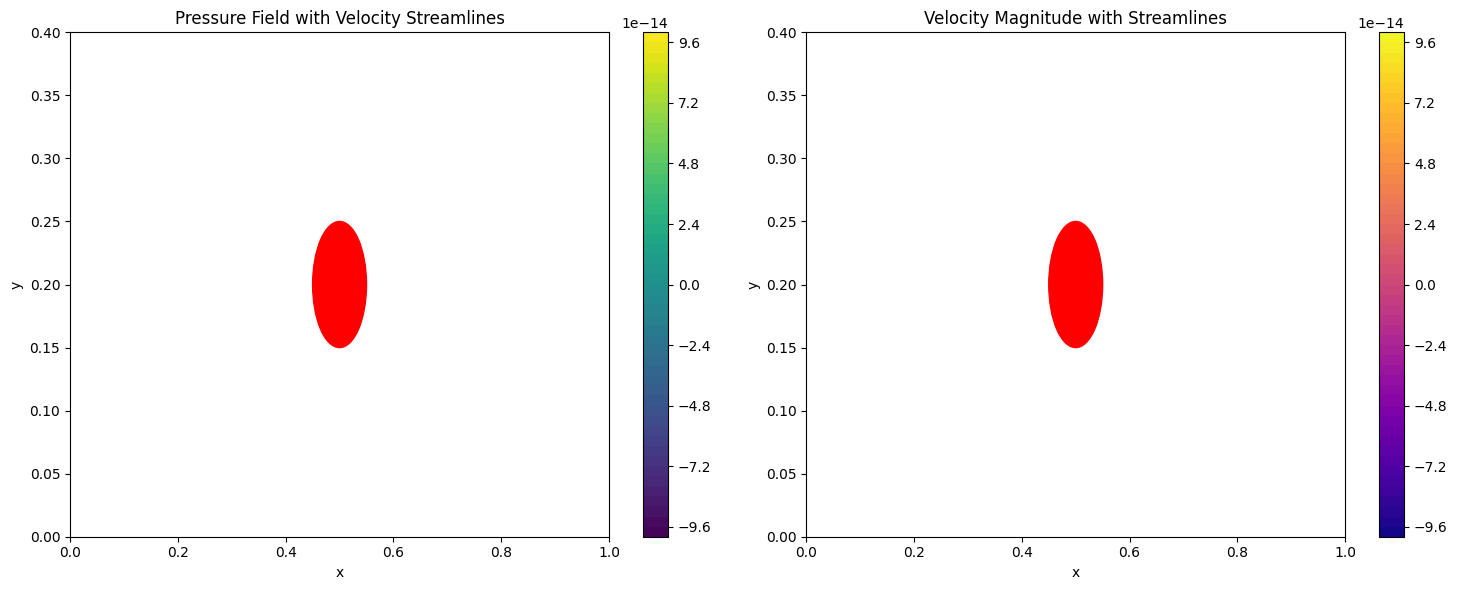

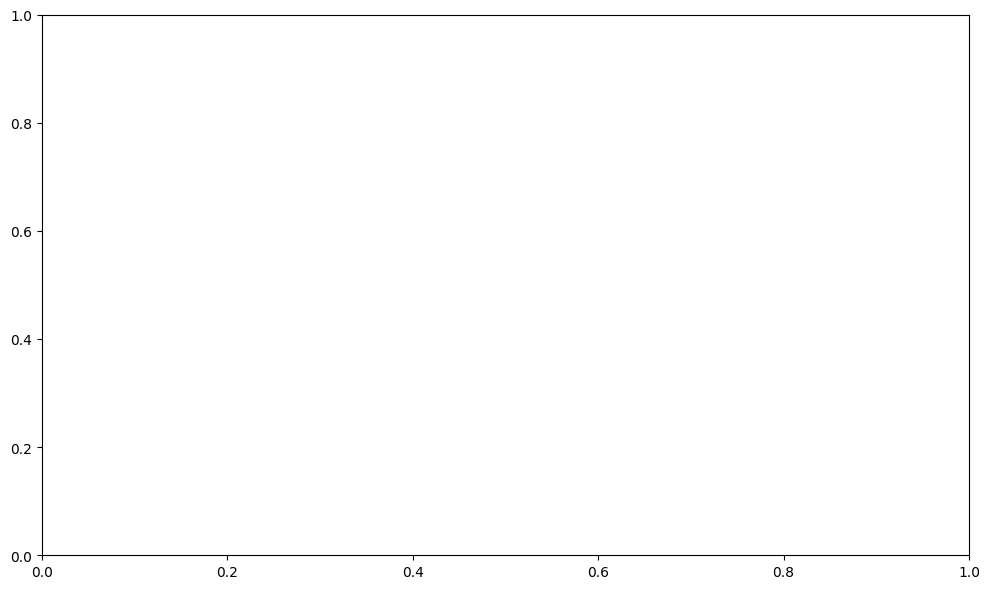

In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 检查CUDA是否可用
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 物理参数
nu = 0.01  # 运动粘度
rho = 1.0  # 密度
inlet_velocity = 1.0  # 入口速度

class PINN_NavierStokes():
    def __init__(self, layers, cylinder_center=(0.5, 0.2), cylinder_radius=0.05):
        # 网络结构
        self.layers = layers
        self.cylinder_center = cylinder_center
        self.cylinder_radius = cylinder_radius
        
        # 初始化网络
        self.network()
        
        # 将网络移动到GPU
        self.net = self.net.to(device)
        
        # 优化器
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=0.1, 
            max_iter=1000, 
            max_eval=1000,
            history_size=50, 
            tolerance_grad=1e-07, 
            tolerance_change=1e-09,
            line_search_fn="strong_wolfe"
        )
        
        self.mse = nn.MSELoss()
        self.iter = 0

    def network(self):
        """构建神经网络"""
        layers_list = []
        for i in range(len(self.layers) - 1):
            layer = nn.Linear(self.layers[i], self.layers[i+1])
            # 初始化权重
            if i < len(self.layers) - 2:
                nn.init.xavier_uniform_(layer.weight)
            else:
                nn.init.xavier_uniform_(layer.weight)
            layers_list.append(layer)
            if i < len(self.layers) - 2:  # 最后一层不需要激活函数
                layers_list.append(nn.Tanh())
        
        self.net = nn.Sequential(*layers_list)

    def governing_equations(self, x, y, t):
        """计算Navier-Stokes方程的残差"""
        # 确保输入张量需要梯度
        x = x.requires_grad_(True)
        y = y.requires_grad_(True)
        t = t.requires_grad_(True)
        
        # 网络输出: [u, v, p] (速度分量和压力)
        input_tensor = torch.cat([x, y, t], dim=1)
        output = self.net(input_tensor)
        u, v, p = output[:, 0:1], output[:, 1:2], output[:, 2:3]
        
        # 计算速度的偏导数
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
        
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
        
        # 压力梯度
        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        
        # Navier-Stokes方程残差
        f = u_t + u * u_x + v * u_y + (1.0/rho) * p_x - nu * (u_xx + u_yy)
        g = v_t + u * v_x + v * v_y + (1.0/rho) * p_y - nu * (v_xx + v_yy)
        
        # 连续性方程残差 (质量守恒)
        continuity = u_x + v_y
        
        return u, v, p, f, g, continuity

    def boundary_conditions(self, x, y, t):
        """计算边界条件损失"""
        # 确保输入张量需要梯度
        x = x.requires_grad_(True)
        y = y.requires_grad_(True)
        t = t.requires_grad_(True)
        
        # 网络输出
        input_tensor = torch.cat([x, y, t], dim=1)
        output = self.net(input_tensor)
        u, v, p = output[:, 0:1], output[:, 1:2], output[:, 2:3]
        
        # 计算到圆柱中心的距离
        dist_to_cylinder = torch.sqrt((x - self.cylinder_center[0])**2 + (y - self.cylinder_center[1])**2)
        cylinder_mask = dist_to_cylinder <= self.cylinder_radius + 0.005
        
        # 入口边界 (x=0)
        inlet_mask = torch.abs(x) < 0.005
        
        # 出口边界 (x=1) - 自然边界条件，压力梯度为0
        outlet_mask = torch.abs(x - 1.0) < 0.005
        
        # 上下边界 (y=0, y=0.4) - 无滑移条件
        wall_mask = (torch.abs(y) < 0.005) | (torch.abs(y - 0.4) < 0.005)
        
        # 计算边界损失
        bc_loss = 0.0
        
        # 圆柱边界: 无滑移条件
        if cylinder_mask.any():
            u_cyl = u[cylinder_mask]
            v_cyl = v[cylinder_mask]
            bc_loss += torch.mean(u_cyl**2) + torch.mean(v_cyl**2)
        
        # 入口边界: 指定入口速度
        if inlet_mask.any():
            u_inlet = u[inlet_mask]
            v_inlet = v[inlet_mask]
            bc_loss += torch.mean((u_inlet - inlet_velocity)**2) + torch.mean(v_inlet**2)
        
        # 壁面边界: 无滑移条件
        if wall_mask.any():
            u_wall = u[wall_mask]
            v_wall = v[wall_mask]
            bc_loss += torch.mean(u_wall**2) + torch.mean(v_wall**2)
            
        return bc_loss

    def closure(self, x_col, y_col, t_col, x_bc, y_bc, t_bc):
        """损失函数"""
        self.optimizer.zero_grad()
        
        # 物理方程损失 (残差)
        _, _, _, f, g, continuity = self.governing_equations(x_col, y_col, t_col)
        physics_loss = torch.mean(f**2) + torch.mean(g**2) + torch.mean(continuity**2)
        
        # 边界条件损失
        bc_loss = self.boundary_conditions(x_bc, y_bc, t_bc)
        
        # 总损失
        total_loss = physics_loss + bc_loss
        
        total_loss.backward()
        
        self.iter += 1
        if self.iter % 10 == 0:
            print(f'Iteration: {self.iter}, Total Loss: {total_loss.item():.8f}, '
                  f'Physics Loss: {physics_loss.item():.8f}, BC Loss: {bc_loss.item():.8f}')
        
        return total_loss

    def train(self, epochs=100):
        """训练函数"""
        self.net.train()
        
        for epoch in range(epochs):
            # 生成训练点
            # 物理域内的点 (用于物理方程约束)
            n_col = 500  # 配置点数量
            x_col = torch.rand(n_col, 1, device=device) * 1.0  # x: 0 to 1
            y_col = torch.rand(n_col, 1, device=device) * 0.4  # y: 0 to 0.4
            t_col = torch.rand(n_col, 1, device=device) * 0.5  # t: 0 to 0.5
            
            # 边界点 (用于边界条件约束)
            n_bc = 400
            # 圆柱边界采样
            theta = torch.rand(n_bc//4, 1, device=device) * 2 * np.pi
            x_cyl = self.cylinder_center[0] + self.cylinder_radius * torch.cos(theta)
            y_cyl = self.cylinder_center[1] + self.cylinder_radius * torch.sin(theta)
            
            # 入口边界 (x=0)
            y_inlet = torch.rand(n_bc//4, 1, device=device) * 0.4
            x_inlet = torch.zeros_like(y_inlet)
            
            # 出口边界 (x=1)
            y_outlet = torch.rand(n_bc//4, 1, device=device) * 0.4
            x_outlet = torch.ones_like(y_outlet)
            
            # 上下边界
            x_wall = torch.rand(n_bc//2, 1, device=device)
            y_wall_top = torch.ones(n_bc//4, 1, device=device) * 0.4
            y_wall_bottom = torch.zeros(n_bc//4, 1, device=device)
            
            # 合并边界点
            x_bc = torch.cat([x_cyl, x_inlet, x_outlet, x_wall[:n_bc//4], x_wall[n_bc//4:]], dim=0)
            y_bc = torch.cat([y_cyl, y_inlet, y_outlet, y_wall_top, y_wall_bottom], dim=0)
            t_bc = torch.rand_like(x_bc) * 0.5
            
            # 调用优化器
            def closure_wrapper():
                return self.closure(x_col, y_col, t_col, x_bc, y_bc, t_bc)
            
            self.optimizer.step(closure_wrapper)

    def predict(self, x, y, t):
        """预测速度场和压力场"""
        self.net.eval()
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32, device=device).reshape(-1, 1)
            y_tensor = torch.tensor(y, dtype=torch.float32, device=device).reshape(-1, 1)
            t_tensor = torch.tensor(t, dtype=torch.float32, device=device).reshape(-1, 1)
            
            input_tensor = torch.cat([x_tensor, y_tensor, t_tensor], dim=1)
            output = self.net(input_tensor)
            u, v, p = output[:, 0:1], output[:, 1:2], output[:, 2:3]
            
        return u.cpu().numpy(), v.cpu().numpy(), p.cpu().numpy()

# 创建PINN模型
layers = [3, 50, 50, 50, 50, 50, 3]  # [输入: x,y,t -> 输出: u, v, p]
pinn = PINN_NavierStokes(layers)

# 训练模型
print("开始训练PINN模型...")
try:
    pinn.train(epochs=10)  # 减少epoch数以加快训练
    print("训练完成!")
except Exception as e:
    print(f"训练过程中出现错误: {e}")

# 创建网格用于可视化
x_range = np.linspace(0, 1, 100)
y_range = np.linspace(0, 0.4, 50)
X, Y = np.meshgrid(x_range, y_range)
x_flat = X.flatten()
y_flat = Y.flatten()

# 静态可视化 - 速度流线图
def plot_flow_field():
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 计算t=0.25时刻的场
    t_static = np.ones_like(x_flat) * 0.25
    try:
        u_static, v_static, p_static = pinn.predict(x_flat, y_flat, t_static)
        
        U_static = u_static.reshape(X.shape)
        V_static = v_static.reshape(Y.shape)
        P_static = p_static.reshape(X.shape)
        
        # 左图：压力场
        contour1 = ax1.contourf(X, Y, P_static, levels=50, cmap='viridis')
        ax1.streamplot(X, Y, U_static.reshape(X.shape), V_static.reshape(Y.shape), 
                      color='white', density=1.5, linewidth=0.8, arrowsize=1)
        cylinder1 = plt.Circle(pinn.cylinder_center, pinn.cylinder_radius, color='red', zorder=5)
        ax1.add_patch(cylinder1)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title('Pressure Field with Velocity Streamlines')
        plt.colorbar(contour1, ax=ax1)
        
        # 右图：速度幅值
        speed = np.sqrt(U_static**2 + V_static**2)
        contour2 = ax2.contourf(X, Y, speed, levels=50, cmap='plasma')
        ax2.streamplot(X, Y, U_static, V_static, color='white', density=1.5, linewidth=0.8, arrowsize=1)
        cylinder2 = plt.Circle(pinn.cylinder_center, pinn.cylinder_radius, color='red', zorder=5)
        ax2.add_patch(cylinder2)
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_title('Velocity Magnitude with Streamlines')
        plt.colorbar(contour2, ax=ax2)
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"可视化过程中出现错误: {e}")
        print("这可能是因为模型训练不充分或网络输出不稳定")

plot_flow_field()

# 如果训练成功，可以尝试动画
try:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    def animate(t_frame):
        ax.clear()
        
        # 计算当前时间步的速度场和压力场
        t_flat = np.ones_like(x_flat) * t_frame * 0.05  # 时间从0到1.5变化
        
        u_pred, v_pred, p_pred = pinn.predict(x_flat, y_flat, t_flat)
        
        # 重塑为网格形式
        U = u_pred.reshape(X.shape)
        V = v_pred.reshape(Y.shape)
        P = p_pred.reshape(X.shape)
        
        # 绘制压力场
        contour = ax.contourf(X, Y, P, levels=50, cmap='viridis')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Pressure Field at t={t_frame*0.05:.2f}')
        
        # 绘制圆柱
        cylinder = plt.Circle(pinn.cylinder_center, pinn.cylinder_radius, color='red', zorder=5)
        ax.add_patch(cylinder)
        
        # 可选：绘制速度矢量
        skip = 5  # 每5个点绘制一个矢量
        ax.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
                  U[::skip, ::skip], V[::skip, ::skip], 
                  alpha=0.5, scale=5, color='white', width=0.002)
        
        if t_frame == 0:  # 只在第一帧添加颜色条
            plt.colorbar(contour, ax=ax)
    
    # 创建动画
    ani = animation.FuncAnimation(fig, animate, frames=30, interval=300, repeat=True)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"动画创建失败: {e}")
    print("可能是由于模型训练不充分导致的数值不稳定")





In [15]:
from matplotlib.animation import PillowWriter

ani.save('karman_vortex_street.gif', writer=PillowWriter(fps=5))

/tmp/ipykernel_312620/2173895397.py:322: UserWarning: Adding colorbar to a different Figure <Figure size 1000x600 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(contour, ax=ax)
/tmp/ipykernel_312620/2173895397.py:322: UserWarning: Adding colorbar to a different Figure <Figure size 1000x600 with 3 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(contour, ax=ax)


<Figure size 640x480 with 0 Axes>

In [3]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import matplotlib.animation as animation

data = scipy.io.loadmat('./NS_PINN/cylinder_wake.mat')

In [5]:
data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Sep 22 23:02:15 2017',
 '__version__': '1.0',
 '__globals__': [],
 'X_star': array([[ 1.        , -2.        ],
        [ 1.07070707, -2.        ],
        [ 1.14141414, -2.        ],
        ...,
        [ 7.85858586,  2.        ],
        [ 7.92929293,  2.        ],
        [ 8.        ,  2.        ]]),
 't': array([[ 0. ],
        [ 0.1],
        [ 0.2],
        [ 0.3],
        [ 0.4],
        [ 0.5],
        [ 0.6],
        [ 0.7],
        [ 0.8],
        [ 0.9],
        [ 1. ],
        [ 1.1],
        [ 1.2],
        [ 1.3],
        [ 1.4],
        [ 1.5],
        [ 1.6],
        [ 1.7],
        [ 1.8],
        [ 1.9],
        [ 2. ],
        [ 2.1],
        [ 2.2],
        [ 2.3],
        [ 2.4],
        [ 2.5],
        [ 2.6],
        [ 2.7],
        [ 2.8],
        [ 2.9],
        [ 3. ],
        [ 3.1],
        [ 3.2],
        [ 3.3],
        [ 3.4],
        [ 3.5],
        [ 3.6],
        [ 3.7],
        [ 

In [7]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X_star', 't', 'U_star', 'p_star'])

In [10]:
data['X_star'].shape

(5000, 2)

In [13]:
data['t'].shape


(200, 1)